<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for retrieving data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses Python 3.10 and scikit-learn 1.1.1.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:


**[Pipeline inspection](#inspection)** <br>
&nbsp;&nbsp;[Read training data](#read)<br>
&nbsp;&nbsp;[Train and test data split](#split)<br>
&nbsp;&nbsp;[Create pipeline](#preview_model_to_python_code)<br>
&nbsp;&nbsp;[Train pipeline model](#train)<br>
&nbsp;&nbsp;[Test pipeline model](#test_model)<br>

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - scikit-learn,
 - xgboost


In [1]:
!pip install ibm-watson-machine-learning | tail -n 1
!pip install autoai-libs==1.14.9 | tail -n 1
!pip install scikit-learn==1.1.1 | tail -n 1
!pip install xgboost==1.6.2 | tail -n 1


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [2]:
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='beac5398-767d-4d68-8fae-aed214a90e27'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/6b80d5a2-2b09-4ff5-bde7-f6262056dd01/wml_data/277ae8be-9deb-453c-96ed-7420e96ee8e3/data/automl',
        model_location='auto_ml/6b80d5a2-2b09-4ff5-bde7-f6262056dd01/wml_data/277ae8be-9deb-453c-96ed-7420e96ee8e3/data/automl/model.zip',
        training_status='auto_ml/6b80d5a2-2b09-4ff5-bde7-f6262056dd01/wml_data/277ae8be-9deb-453c-96ed-7420e96ee8e3/training-status.json'
    )
)

The following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [3]:
experiment_metadata = dict(
    prediction_type='binary',
    prediction_column='Result',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=3,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    include_only_estimators=['RandomForestClassifierEstimator', 'DecisionTreeClassifierEstimator', 'XGBClassifierEstimator'],
    deployment_url='https://us-south.ml.cloud.ibm.com',
    project_id='ec07fd0d-a509-4176-a1b5-2a694e05c697',
    positive_label=1,
    drop_duplicates=True
)

## Set `n_jobs` parameter to the number of available CPUs

In [4]:
import os, ast
CPU_NUMBER = 2
if 'RUNTIME_HARDWARE_SPEC' in os.environ:
    CPU_NUMBER = int(ast.literal_eval(os.environ['RUNTIME_HARDWARE_SPEC'])['num_cpu'])

<a id="connection"></a>
## Watson Machine Learning connection

This cell defines the credentials required to work with the Watson Machine Learning service.

**Action**: Provide the IBM Cloud apikey, For details, see [documentation](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [5]:
api_key = '9-2L7L1MrIEhxIm69IPUof2ojmFd4bWT3qhMR5d0U3iR'

In [6]:
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

In [7]:
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(wml_credentials)

if 'space_id' in experiment_metadata:
    wml_client.set.default_space(experiment_metadata['space_id'])
else:
    wml_client.set.default_project(experiment_metadata['project_id'])
    
training_data_references[0].set_client(wml_client)

<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

**Note**: If reading data results in an error, provide data as Pandas DataFrame object, for example, reading .CSV file with `pandas.read_csv()`. It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.

In [8]:
train_X, test_X, train_y, test_y = training_data_references[0].read(experiment_metadata=experiment_metadata, with_holdout_split=True, use_flight=False)

In [9]:
df = training_data_references[0].read(experiment_metadata=experiment_metadata, with_holdout_split=False, use_flight=False)
print(df.shape)
print(df.columns)

(1000, 21)
Index(['Check_Account ', 'Duration', 'Credit_history', 'Purpose',
       'Credit amount ', 'Saving_account', 'Employment', 'Install_rate',
       'Personal_status', 'Other_debrotors', 'Present_residence', 'Property',
       'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job',
       'Num_dependents', 'Telephone', 'Foreign', 'Result'],
      dtype='object')


## Create pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

#### Import statements.

In [10]:
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from autoai_libs.estimators.xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from autoai_libs.cognito.transforms.transform_utils import TA1
from autoai_libs.cognito.transforms.transform_utils import FS1
from autoai_libs.utils.fc_methods import is_not_categorical, is_non_negative
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
from autoai_libs.cognito.transforms.transform_utils import TNoOp

%matplotlib inline
import matplotlib.patches as mpatches

### EDA data

In [11]:
df.describe()

,Duration,Credit amount,Install_rate,Present_residence,Age,Num_credits,Num_dependents,Result
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


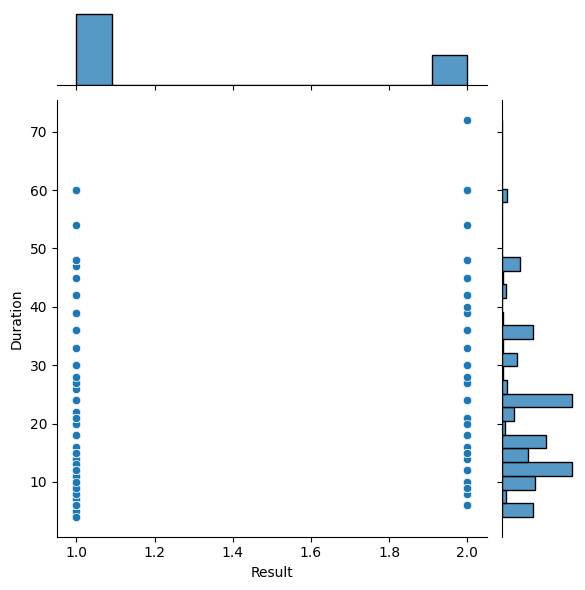

In [12]:
# Relationship between Duration and Result
sns.jointplot(x=df["Result"], y=df["Duration"], kind='scatter')

plt.show()

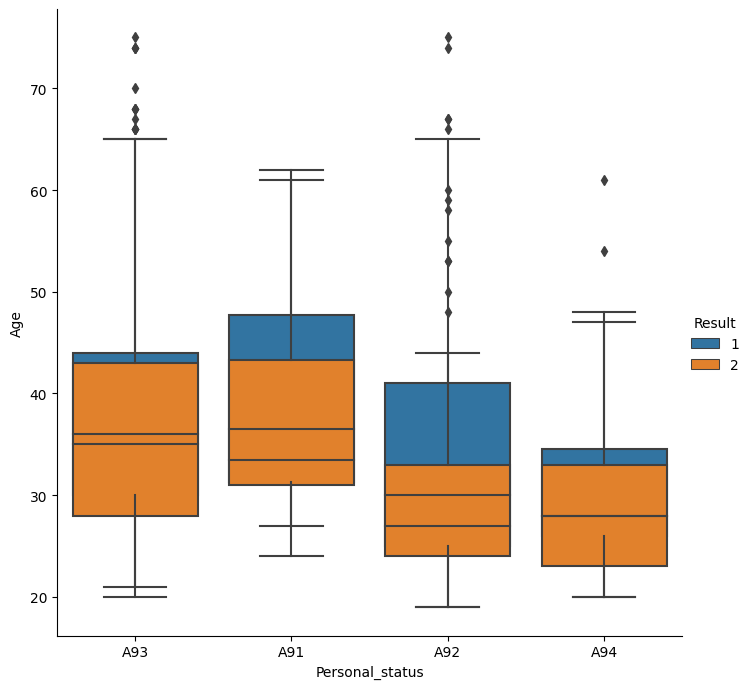

In [13]:
sns.catplot(x="Personal_status", y="Age", hue="Result",
            kind="box", dodge=False, data=df,height=7)

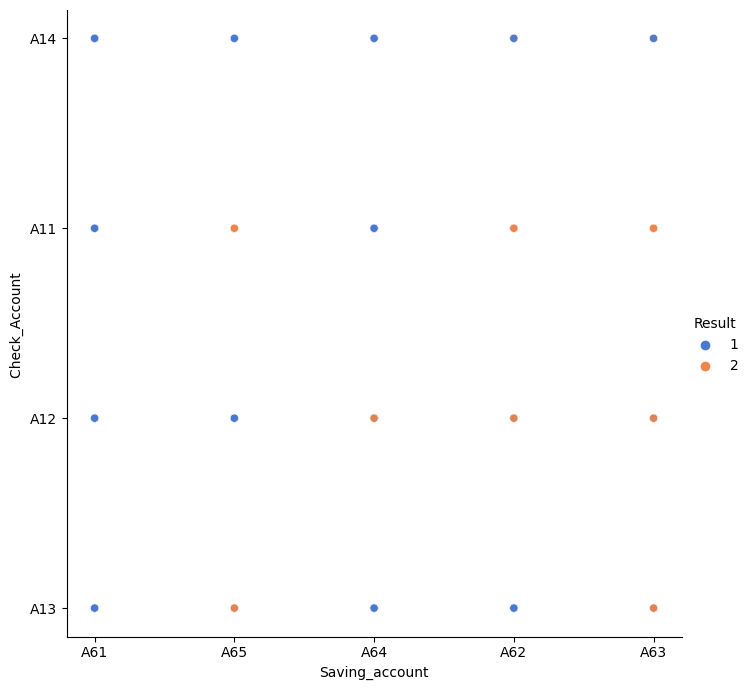

In [14]:
sns.relplot(x="Saving_account", y="Check_Account ", hue="Result",
            sizes=(400, 400), alpha=0.9, palette="muted",
            height=7, data=df)

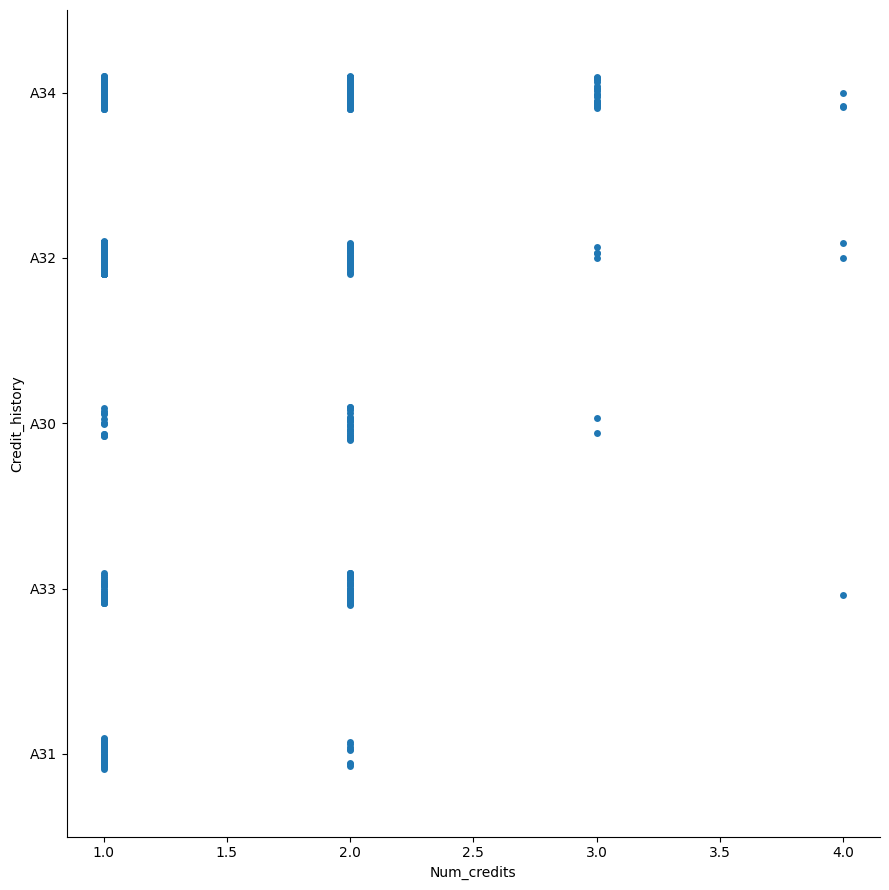

In [15]:
sns.catplot(x="Num_credits", y="Credit_history", data=df, height=9)

#### Pre-processing & Estimator.

In [16]:
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
    ]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "char_str", "int_num", "char_str", "char_str", "char_str", "char_str",
        "int_num", "char_str", "char_str", "int_num", "char_str", "int_num",
        "char_str", "char_str", "int_num", "char_str", "int_num", "char_str",
        "char_str",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
        [], [],
    ],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=float("nan"),
    filling_values_list=[
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"), float("nan"),
        float("nan"), float("nan"), float("nan"), float("nan"),
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=float("nan"),
    sklearn_version_family="1",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="1",
)
pipeline_0 = make_pipeline(
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(
    dtypes_list=["int_num"], missing_values_reference_list=[]
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(use_scaler_flag=False)
pipeline_1 = make_pipeline(
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0,
    permutation_indices=[
        0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4,
    ],
)

#### Pipeline XGBClassifier

In [17]:
xgb_classifier = XGBClassifier(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    gpu_id=-1,
    grow_policy="depthwise",
    interaction_constraints="",
    learning_rate=0.300000012,
    max_bin=256,
    max_cat_to_onehot=4,
    max_delta_step=0,
    max_depth=3,
    max_leaves=0,
    min_child_weight=1,
    missing=float("nan"),
    monotone_constraints="()",
    n_jobs=CPU_NUMBER,
    num_parallel_tree=1,
    predictor="auto",
    random_state=33,
    reg_alpha=0,
    reg_lambda=1,
    sampling_method="uniform",
    scale_pos_weight=1,
    subsample=1,
    tree_method="hist",
    validate_parameters=1,
    verbosity=0,
    nthread=2,
    silent=True,
    seed=33,
)




#### Pipeline RandomForestClassifier

In [18]:
random_forest_classifier = RandomForestClassifier(
    class_weight="balanced",
    criterion="entropy",
    max_depth=5,
    max_features=0.24167589580505217,
    min_samples_leaf=2,
    n_estimators=34,
    n_jobs=CPU_NUMBER,
    random_state=33,
)

#### Pipeline DecisionTreeClassifier

In [19]:
# Feature transformation for numeric column: round elements of column to the nearest integer.
ta1_0 = TA1(
    fun=np.rint,
    name="round",
    datatypes=["numeric"],
    feat_constraints=[is_not_categorical],
    col_names=[
        "Check_Account ", "Duration", "Credit_history", "Purpose",
        "Credit amount ", "Saving_account", "Employment", "Install_rate",
        "Personal_status", "Other_debrotors", "Present_residence", "Property",
        "Age", "Installment_plant", "Housing", "Num_credits", "Job",
        "Num_dependents", "Telephone", "Foreign",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)

# Feature selection retained 20 columns using pairwise correlation
fs1_0 = FS1(
    cols_ids_must_keep=range(0, 20),
    additional_col_count_to_keep=20,
    ptype="classification",
)

# Feature transformation for numeric column: non-negative square-root of columns
ta1_1 = TA1(
    fun=np.sqrt,
    name="sqrt",
    datatypes=["numeric"],
    feat_constraints=[
        is_non_negative,
        is_not_categorical,
    ],
    col_names=[
        "Check_Account ", "Duration", "Credit_history", "Purpose",
        "Credit amount ", "Saving_account", "Employment", "Install_rate",
        "Personal_status", "Other_debrotors", "Present_residence", "Property",
        "Age", "Installment_plant", "Housing", "Num_credits", "Job",
        "Num_dependents", "Telephone", "Foreign", "round(Duration)",
        "round(Credit amount )", "round(Age)",
    ],
    col_dtypes=[
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"), np.dtype("float32"),
        np.dtype("float32"), np.dtype("float32"),
    ],
)

# Feature selection retained 20 columns using pairwise correlation
fs1_1 = FS1(
    cols_ids_must_keep=range(0, 20),
    additional_col_count_to_keep=20,
    ptype="classification",
)


decision_tree_classifier = DecisionTreeClassifier(
    class_weight="balanced", max_features=None, random_state=33
)

#### Pipeline.

In [20]:
pipeline_xgb = make_pipeline(union, numpy_permute_array, xgb_classifier)
pipeline_xgb

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('numpycolumnselector',
                                                                  NumpyColumnSelector(columns=[0,
                                                                                               1,
                                                                                               2,
                                                                                               3,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9,
                                                                                               10,
                                                                                               11,
                                                                                               12,
                                                                                               13,
                                                                                               14,
                                                                                               15,
                                                                                               16,
                                                                                               17,
                                                                                               18,
                                                                                               19])),
                                                                 ('compressstrings',
                                                                  CompressStrings(compress_type='hash',
                                                                                  dtypes_list=['char_str',
                                                                                               'int_num',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'int_num',
                                                                                               'char_str'...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=2, nthread=2,
                               num_parallel_tree=1, objective='binary:logistic',
                               predictor='auto', random_state=33, ...))])

In [21]:
pipeline_rf = make_pipeline(
    union, numpy_permute_array, random_forest_classifier
)
pipeline_rf

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('numpycolumnselector',
                                                                  NumpyColumnSelector(columns=[0,
                                                                                               1,
                                                                                               2,
                                                                                               3,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9,
                                                                                               10,
                                                                                               11,
                                                                                               12,
                                                                                               13,
                                                                                               14,
                                                                                               15,
                                                                                               16,
                                                                                               17,
                                                                                               18,
                                                                                               19])),
                                                                 ('compressstrings',
                                                                  CompressStrings(compress_type='hash',
                                                                                  dtypes_list=['char_str',
                                                                                               'int_num',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'int_num',
                                                                                               'char_str'...
                                                                 ('float32_transform',
                                                                  float32_transform())]))])),
                ('numpypermutearray',
                 NumpyPermuteArray(axis=0,
                                   permutation_indices=[0, 1, 2, 3, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19,
                                                        4])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        max_features=0.24167589580505217,
                                        min_samples_leaf=2, n_estimators=34,
   

In [22]:
pipeline_cart = make_pipeline(
    union,
    numpy_permute_array,
    ta1_0,
    fs1_0,
    ta1_1,
    fs1_1,
    decision_tree_classifier,
)
pipeline_cart

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('numpycolumnselector',
                                                                  NumpyColumnSelector(columns=[0,
                                                                                               1,
                                                                                               2,
                                                                                               3,
                                                                                               5,
                                                                                               6,
                                                                                               7,
                                                                                               8,
                                                                                               9,
                                                                                               10,
                                                                                               11,
                                                                                               12,
                                                                                               13,
                                                                                               14,
                                                                                               15,
                                                                                               16,
                                                                                               17,
                                                                                               18,
                                                                                               19])),
                                                                 ('compressstrings',
                                                                  CompressStrings(compress_type='hash',
                                                                                  dtypes_list=['char_str',
                                                                                               'int_num',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'char_str',
                                                                                               'int_num',
                                                                                               'char_str'...
                 autoai_libs.cognito.transforms.transform_utils.TA1(fun = numpy.sqrt, name = 'sqrt', datatypes = ['numeric'], feat_constraints = [<cyfunction is_non_negative at 0x7f8bbcb6ee10>, <cyfunction is_not_categorical at 0x7f8bbcc88380>], tgraph = None, apply_all = True, col_names = ['Check_Account ', 'Duration', 'Credit_history', 'Purpose', 'Credit amount ', 'Saving_account', 'Employment', 'Install_rate', 'Personal_status', 'Other_debrotors', 'Present_residence', 'Property', 'Age', 'Installment_plant', 'Housing', 'Num_credits', 'Job', 'Num_dependents', 'Telephone', 'Foreign', 'round(Duration)', 'round(Credit amount )', 'round(Age)'], col_dtypes = [dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [23]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])
print(scorer)
print(train_y.value_counts())

make_scorer(accuracy_score)
Result
1         630
2         270
dtype: int64


<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [24]:
pipeline_xgb.fit(train_X.values, train_y.values.ravel());

In [25]:
pipeline_rf.fit(train_X.values, train_y.values.ravel());

In [26]:
pipeline_cart.fit(train_X.values, train_y.values.ravel());

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score



def full_multiclass_report(model,
                           X_test,
                           y_true):

  
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(X_test)
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)

    TP = cnf_matrix[0,0]
    TN = cnf_matrix[1,1]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]

    print('\nTrue Positives(Actual Positive:1 and Predict Positive:1) = ', TP)

    print('\nTrue Negatives(Actual Negative:0 and Predict Negative:0) = ', TN)

    print('\nFalse Positives(Actual Negative:0 but Predict Positive:1) = ', FP)

    print('\nFalse Negatives(Actual Positive:1 but Predict Negative:0) = ', FN)
    
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

    print('\n\nAccuracy : {0:0.4f}'.format(classification_accuracy))

    precision = TP / float(TP + FP)


    print('\nPrecision : {0:0.4f}'.format(precision))
    
    recall = TP / float(TP + FN)

    print('\nRecall or Sensitivity : {0:0.4f}'.format(recall))
    f1_score = (2 * precision  * recall)/ float(precision  + recall)

    print('\nF1 score : {0:0.4f}'.format(f1_score))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                             display_labels=[1,2])
    disp.plot()
    plt.show()
    



True Positives(Actual Positive:1 and Predict Positive:1) =  62

True Negatives(Actual Negative:0 and Predict Negative:0) =  13

False Positives(Actual Negative:0 but Predict Positive:1) =  8

False Negatives(Actual Positive:1 but Predict Negative:0) =  17


Accuracy : 0.7500

Precision : 0.8857

Recall or Sensitivity : 0.7848

F1 score : 0.8322


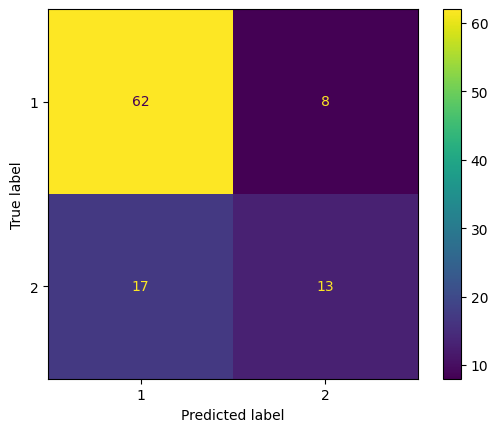

In [28]:
full_multiclass_report(pipeline_xgb, test_X.values, test_y.values)

<BarContainer object of 20 artists>

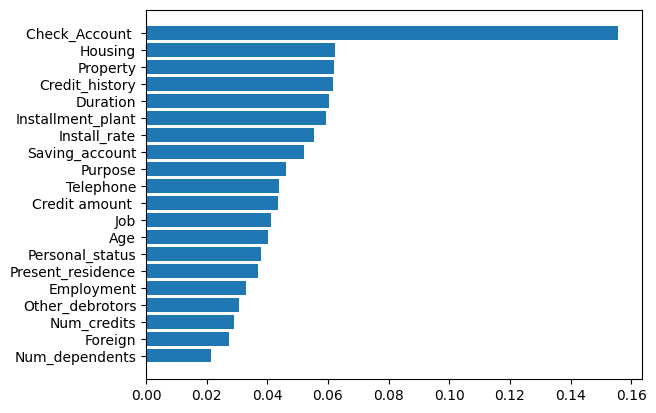

In [29]:
feature_names = train_X.columns
feature_importances = pipeline_xgb[-1].feature_importances_

sorted_idx = feature_importances.argsort()

plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])



True Positives(Actual Positive:1 and Predict Positive:1) =  56

True Negatives(Actual Negative:0 and Predict Negative:0) =  17

False Positives(Actual Negative:0 but Predict Positive:1) =  14

False Negatives(Actual Positive:1 but Predict Negative:0) =  13


Accuracy : 0.7300

Precision : 0.8000

Recall or Sensitivity : 0.8116

F1 score : 0.8058


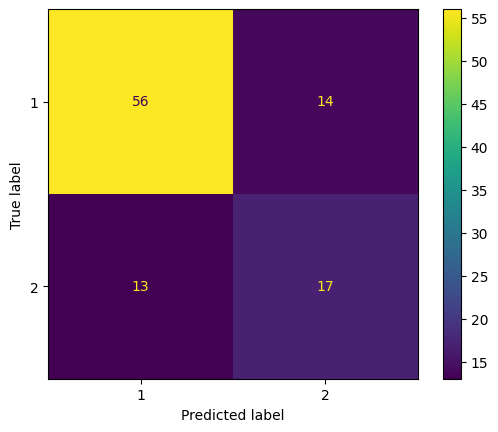

In [30]:
full_multiclass_report(pipeline_rf, test_X.values, test_y.values )


True Positives(Actual Positive:1 and Predict Positive:1) =  56

True Negatives(Actual Negative:0 and Predict Negative:0) =  10

False Positives(Actual Negative:0 but Predict Positive:1) =  14

False Negatives(Actual Positive:1 but Predict Negative:0) =  20


Accuracy : 0.6600

Precision : 0.8000

Recall or Sensitivity : 0.7368

F1 score : 0.7671


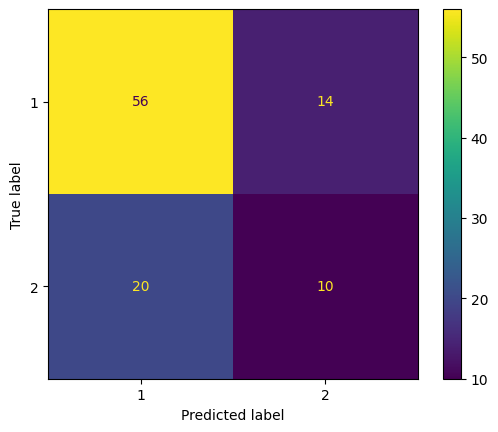

In [31]:
full_multiclass_report(pipeline_cart, test_X.values, test_y.values )

## Selector feature


True Positives(Actual Positive:1 and Predict Positive:1) =  64

True Negatives(Actual Negative:0 and Predict Negative:0) =  12

False Positives(Actual Negative:0 but Predict Positive:1) =  6

False Negatives(Actual Positive:1 but Predict Negative:0) =  18


Accuracy : 0.7600

Precision : 0.9143

Recall or Sensitivity : 0.7805

F1 score : 0.8421


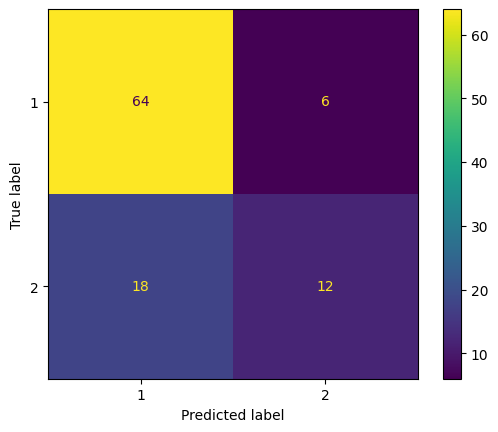

In [32]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=14)

pipeline_kbest_xgb = make_pipeline(union, numpy_permute_array, selector, xgb_classifier)

pipeline_kbest_xgb.fit(train_X.values, train_y.values.ravel())
full_multiclass_report(pipeline_kbest_xgb, test_X.values, test_y.values)

<BarContainer object of 14 artists>

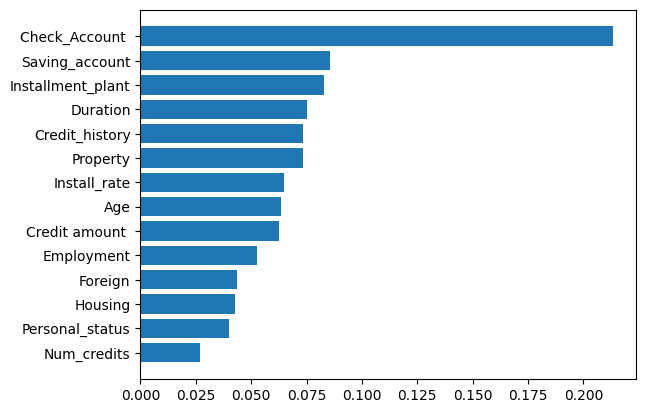

In [33]:


feature_names = train_X.columns[pipeline_kbest_xgb[2].get_support()]
feature_importances = pipeline_kbest_xgb[-1].feature_importances_

sorted_idx = feature_importances.argsort()

plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])



In [34]:
df_scores = pd.DataFrame(pipeline_kbest_xgb[2].scores_)
df_columns = pd.DataFrame(train_X.columns)
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']
print(feature_scores.sort_values(by=['Score'], ascending=False))

         Feature_Name         Score
4      Credit amount   74040.041909
1            Duration    198.312520
12                Age     53.613263
0      Check_Account      17.475795
5      Saving_account     12.152775
8     Personal_status     12.107249
11           Property     10.393778
14            Housing      5.520279
19            Foreign      5.383754
13  Installment_plant      3.888889
6          Employment      3.381630
2      Credit_history      1.927573
7        Install_rate      1.765969
15        Num_credits      1.400000
10  Present_residence      0.484796
3             Purpose      0.413767
18          Telephone      0.385555
9     Other_debrotors      0.014528
16                Job      0.005582
17     Num_dependents      0.005521
